Make sure you have a data folder in the parent directory of this notebook. \
The data folder should contain the following files:
111g0L.h5
112g0L.h5

Create folders named filtered, fragments and binary in the data folder.

In [2]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from tqdm import tqdm
from icecream import ic
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint

1. Readable format

In [4]:
def convert_hdf5_to_csv(hdf5_file_path, output_csv_path):
    # Read the HDF5 file
    with h5py.File(hdf5_file_path, 'r') as file:
         eeg = file.get('EEG')
         # Get the keys of all datasets in the HDF5 file
         column_names_dataset = np.array(eeg.get('block0_items'))
         matrix_dataset = np.array(eeg.get('block0_values'))

    # Convert the matrix to a DataFrame with column names
    df = pd.DataFrame(matrix_dataset, columns=column_names_dataset)

    # Save the data to CSV
    df.to_csv(output_csv_path)

In [15]:
input_hdf5_files = [ 
    r'../data/111g0L.h5',
    r'../data/112g0L.h5',
]

output_csv_paths = [ 
    r'../data/111g0L.csv',
    r'../data/112g0L.csv',
]

for input_hdf5_file, output_csv_path in zip(input_hdf5_files, output_csv_paths):
    convert_hdf5_to_csv(input_hdf5_file, output_csv_path)

2. Data Filtration

In [5]:
def filter_data(filename):
    # Replace 'your_data.csv' with your actual filename
    data = pd.read_csv(filename)

    # Columns start with channel 1
    channels = data.columns[1:]

    # Extract data for each channel as a NumPy array
    channel_data = {}
    for channel in channels:
        channel_data[channel] = data[channel].to_numpy()

    # Filter for Delta band (1-4 Hz) with 200 Hz sampling rate
    lowcut = 1
    highcut = 4
    fs = 200

    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = signal.butter(order, [low, high], btype='bandpass')
        return b, a

    # Filter each channel's data
    filtered_data = {}
    for channel, data in channel_data.items():
        b, a = butter_bandpass(lowcut, highcut, fs)
        filtered_data[channel] = signal.filtfilt(b, a, data)

    # Save the filtered data to a new CSV file
    filtered_data_df = pd.DataFrame(filtered_data)
    filtered_data_df.to_csv('../data/filtered/' + filename.split('/')[-1])

In [19]:
filter_data('../data/111g0L.csv')
filter_data('../data/112g0L.csv')

3. Data Reconstruction and Fragmentation

In [6]:
"""
Truncate the original iEEG time series by taking all the seizure time points along with 5000 time points from before as well as after seizure.
file_id     episode     start       dt  SzOnLoc         tend	tend_sec	tsz	    tsz_sec	dt_s
111	        15:42:30    15:40:46	104	L mesial temp	43101	215.505	    34974	174.87	40.635
112	        17:04:35    17:02:51	104	L mesial temp	38828	194.14	    26999	134.995	59.145
113	        19:42:49    19:41:06	103	R mesial temp	35820	179.1	    25562	127.81	51.29
"""


def truncate_data(data, dt, tstart, tend):
    channels = data.columns[1:]

    # Extract data for each channel as a NumPy array
    channel_data = {}
    for channel in channels:
        channel_data[channel] = data[channel].to_numpy()

    # Truncate data start-5000:end+5000
    truncated_data = {}
    for channel, data in channel_data.items():
        truncated_data[channel] = data[tstart - 5000 : tend + 5000]

    # Save the truncated data to a new CSV file
    truncated_data_df = pd.DataFrame(truncated_data)

    return truncated_data_df


"""
Remove reference channels and any channels that start with G, F, I. Column names must be only the channel names without any other characters in the string.
Reference channels after cleaning: "b'SEEG TLR03'","b'SEEG TLR04'"
"""


def channel_cleaning(data):
    data = data.drop(columns=["b'SEEG TLR03'", "b'SEEG TLR04'"])

    channels = data.columns[1:]
    cleaned_channels = []

    # "b'SEEG TBAL1'" -> "TBAL1"
    for channel in channels:
        cleaned_channels.append(channel.split()[-1].replace("'", ""))
    # Rename the columns
    data.columns = [""] + cleaned_channels
    # Remove any channels that start with G, F, I
    data = data.drop(
        columns=[
            channel
            for channel in cleaned_channels
            if channel.startswith(("G", "F", "I"))
        ]
    )

    return data


"""
Fragmentize the truncated time series into 14 parts.
Scheme: b/f seizure + seizure + a/f seizure = 2+10+2
Length of the fragments, separately in the three regions, must be identical.
"""


def fragmentize_data(data, filename):
    channels = data.columns[1:]
    len = data.shape[0]
    fragment_length = len // 14

    channel_data = {}
    for channel in channels:
        channel_data[channel] = data[channel]

    # Fragmentize data
    for i in range(14):
        fragment = {}
        for channel, data in channel_data.items():
            fragment[channel] = data[i * fragment_length : (i + 1) * fragment_length]
        fragment_df = pd.DataFrame(fragment)
        fragment_df.to_csv('../data/fragments/' + filename.split('/')[-1].split('.')[0] + f'_{i}.csv')

In [22]:
data = pd.read_csv('../data/filtered/111g0L.csv')
truncated_data = truncate_data(data, 104, 34974, 43101)
cleaned_data = channel_cleaning(truncated_data)
fragmentize_data(cleaned_data, '../data/filtered/111g0L.csv')

data = pd.read_csv('../data/filtered/112g0L.csv')
truncated_data = truncate_data(data, 104, 26999, 38828)
cleaned_data = channel_cleaning(truncated_data)
fragmentize_data(cleaned_data, '../data/filtered/112g0L.csv')

4. Network Construction

In [3]:
'''
Construct correlation matrix (CM), use Phase Correlation. So, you see dimension of a CM must be n × n; n= no of channels in time series.
'''
def construct_correlation_matrix(data):
    # Columns start with channel 1
    channels = data.columns[1:]
    
    # Extract data for each channel as a NumPy array
    channel_data = {}
    for channel in channels:
        channel_data[channel] = data[channel].to_numpy()

    # Construct correlation matrix
    correlation_matrix = np.zeros((len(channels), len(channels)))
    for i, (channel1, data1) in enumerate(channel_data.items()):
        for j, (channel2, data2) in enumerate(channel_data.items()):
            correlation_matrix[i, j] = np.corrcoef(data1, data2)[0, 1]

    # Return the correlation matrix
    return correlation_matrix

'''
Binarize the matrix by picking up threshold in such a way so that all the channels are recruited in the network.
'''

def binarize_correlation_matrix(correlation_matrix):
    # Start as threshold = 1 with step -0.1
    # As soon as all the channels are recruited, stop and return the binary matrix
    # GCC of the binary matrix is the network
    threshold = 1
    while True:
        binary_matrix = np.where(correlation_matrix > threshold, 1, 0)
        # diagonal elems 0
        np.fill_diagonal(binary_matrix, 0)
        
        # Check if all the channels are recruited. Recruited means the graph is connected.        
        if nx.is_connected(nx.convert_matrix.from_numpy_array(binary_matrix)):
            print(f'Threshold: {threshold}')
            break

        if threshold < 0:
            break
        threshold -= 0.1

    return binary_matrix

In [24]:
for i in range(14):
    print(f'Processing 111g0L_{i}')
    data = pd.read_csv(f'../data/fragments/111g0L_{i}.csv')
    correlation_matrix = construct_correlation_matrix(data)
    binary_matrix = binarize_correlation_matrix(correlation_matrix)
    # Save as 0 and 1
    np.savetxt(f'../data/binary/111g0L_{i}.csv', binary_matrix, fmt='%d', delimiter=',')

for i in range(14):
    print(f'Processing 112g0L_{i}')
    data = pd.read_csv(f'../data/fragments/112g0L_{i}.csv')
    correlation_matrix = construct_correlation_matrix(data)
    binary_matrix = binarize_correlation_matrix(correlation_matrix)
    # Save as 0 and 1
    np.savetxt(f'../data/binary/112g0L_{i}.csv', binary_matrix, fmt='%d', delimiter=',')

Processing 111g0L_0
Threshold: 0.5000000000000001
Processing 111g0L_1
Threshold: 0.30000000000000016
Processing 111g0L_2
Threshold: 0.40000000000000013
Processing 111g0L_3
Threshold: 0.40000000000000013
Processing 111g0L_4
Threshold: 0.40000000000000013
Processing 111g0L_5
Threshold: 0.5000000000000001
Processing 111g0L_6
Threshold: 0.40000000000000013
Processing 111g0L_7
Threshold: 0.5000000000000001
Processing 111g0L_8
Threshold: 0.40000000000000013
Processing 111g0L_9
Threshold: 0.5000000000000001
Processing 111g0L_10
Threshold: 0.20000000000000015
Processing 111g0L_11
Threshold: 0.6000000000000001
Processing 111g0L_12
Threshold: 0.6000000000000001
Processing 111g0L_13
Threshold: 0.6000000000000001
Processing 112g0L_0
Threshold: 0.40000000000000013
Processing 112g0L_1
Threshold: 0.40000000000000013
Processing 112g0L_2
Threshold: 0.5000000000000001
Processing 112g0L_3
Threshold: 0.5000000000000001
Processing 112g0L_4
Threshold: 0.5000000000000001
Processing 112g0L_5
Threshold: 0.4000

5. Kuramoto Model

In [4]:
class Kuramoto:
    def __init__(self, coupling, dt, T, n_nodes):
        self.dt = dt
        self.T = T
        self.coupling = coupling
        self.n_nodes = n_nodes
        self.natfreqs = np.random.normal(size=self.n_nodes)

    def derivative(self, angles_vec, t, adj_mat, k):
        angles_i, angles_j = np.meshgrid(angles_vec, angles_vec)
        interactions = adj_mat * np.sin(angles_j - angles_i)  # Aij * sin(j-i)
        dxdt = self.natfreqs + k * interactions.sum(
            axis=0
        )  # sum over incoming interactions
        return dxdt

    def integrate(self, angles_vec, adj_mat):
        n_interactions = (adj_mat != 0).sum(axis=0)  # number of incoming interactions
        k = (
            self.coupling / n_interactions
        )  # normalize coupling by number of interactions
        t = np.linspace(0, self.T, int(self.T / self.dt))
        timeseries = odeint(self.derivative, angles_vec, t, args=(adj_mat, k))
        return timeseries.T

    def run(self, adj_mat=None, angles_vec=None):
        angles_vec = 2 * np.pi * np.random.random(size=self.n_nodes)
        return self.integrate(angles_vec, adj_mat)

    @staticmethod
    def phase_coherence(angles_vec):
        suma = sum([(np.e ** (1j * i)) for i in angles_vec])
        return abs(suma / len(angles_vec))

In [5]:
def plot_phase_coupling(file, dt, T, mean, std, save=False):
    
    df = pd.read_csv(file, header=None)
    file = file.split("/")[-1]
    data_num = file.split("_")[-2]
    fragment_num = file.split("_")[-1].split(".")[0]
    print(
        "Generating plot for data_num: ", data_num, " and fragment_num: ", fragment_num
    )

    A = df.values
    print(A)
    adjMatrix = np.array(A)
    n = len(adjMatrix)

    # Run model with different coupling (K) parameters
    coupling_vals = np.linspace(0, 1, 100)
    runs = []
    for coupling in tqdm(coupling_vals):
        model = Kuramoto(coupling=coupling, dt=dt, T=T, n_nodes=n)
        model.natfreqs = np.random.normal(mean, std, n) # normally distributed natfreqs
        act_mat = model.run(adjMatrix)
        runs.append(act_mat)

    runs_array = np.array(runs)

    mean_phase_coherences = []
    std_phase_coherences = []
    for i, coupling in tqdm(enumerate(coupling_vals)):
        r_values = [model.phase_coherence(vec) for vec in runs_array[i, :, -8000:].T]
        r_mean = np.mean(r_values)
        r_std = np.std(r_values)
        mean_phase_coherences.append(r_mean)
        std_phase_coherences.append(r_std)

    # Plot mean phase coherence curve
    plt.figure()
    Kc = np.sqrt(8 / np.pi) * np.std(model.natfreqs)  # analytical result (from paper)
    plt.vlines(Kc, 0, 1, linestyles="--", color="orange", label="analytical prediction")
    plt.plot(
        coupling_vals, mean_phase_coherences, color="blue", label="Mean Phase Coherence"
    )
    plt.xlabel("Coupling (K)")
    plt.ylabel("Phase Coherence (R)")
    plt.title("Phase Coherence vs Coupling Strength")
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig("../figures/" + data_num + "_" + fragment_num + "_phasevscoupling.png")
    else:
        plt.show()

In [7]:
def plot_parameter_fragment(data_num, dt, T, mean, std, save=False):
    '''
    For a single time series take few values of coupling and plot order parameter wrt the 14 segments.
    So it's order parameter vs epileptogenic zone i.e 14 segments.
    The plot will give info of how the oscillators are synchronized throughout different epileptogenic zone at various couplings.
    '''

    data = [ pd.read_csv(f'../data/binary/{data_num}_{i}.csv', header=None) for i in range(14) ]
    data = [df.values for df in data]
    data = np.array(data)
    n_nodes = data[0].shape[0]
    coupling_vals = [0.2, 0.4, 0.6, 0.8]
    order_parameters = []
    
    print(f'Generating plot for data_num: {data_num}')

    for coupling in coupling_vals:
        print(f'Running for coupling: {coupling}')
        model = Kuramoto(coupling=coupling, dt=dt, T=T, n_nodes=n_nodes)
        model.natfreqs = np.random.normal(mean, std, size=n_nodes)  # reset natural frequencies
        order_params = []
        for i in range(14):
            # print(f'Running for segment: {i}')
            act_mat = model.run(data[i])
            r_values = [model.phase_coherence(vec) for vec in act_mat[:, -8000:].T]
            r_mean = np.mean(r_values)
            order_params.append(r_mean)
        order_parameters.append(order_params)

    order_parameters = np.array(order_parameters)
    print(order_parameters.shape)
    
    plt.figure()
    for i, coupling in enumerate(coupling_vals):
        plt.plot(order_parameters[i], label=f'Coupling: {coupling}')
    plt.xlabel('Epileptogenic Zone')
    plt.ylabel('Order Parameter')
    plt.title('Order Parameter (R) vs Epileptogenic Zone for ' + data_num)
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='small')
    plt.grid(True)

    if save:
        plt.savefig(f'../figures/{data_num}_ordervsepz.png')
    else:
        plt.show()

Generating plot for data_num: 111g0L
Running for coupling: 0.2
Running for coupling: 0.4
Running for coupling: 0.6
Running for coupling: 0.8
(4, 14)


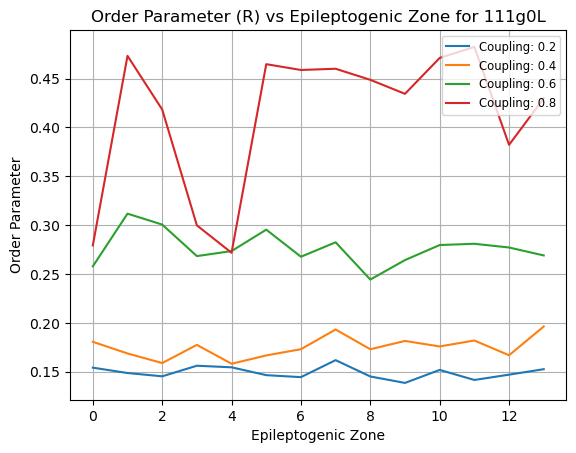

Generating plot for data_num: 112g0L
Running for coupling: 0.2
Running for coupling: 0.4
Running for coupling: 0.6
Running for coupling: 0.8
(4, 14)


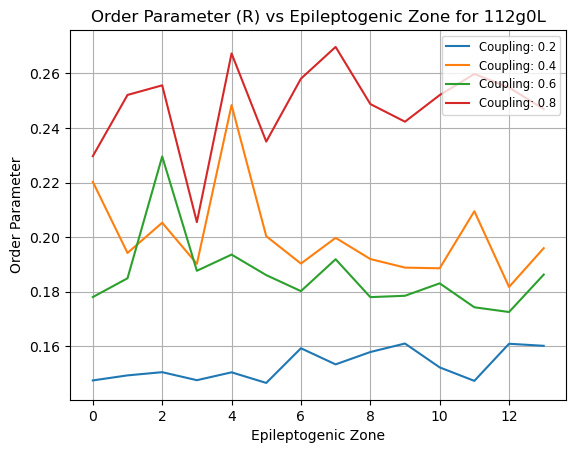

In [29]:
plot_parameter_fragment('111g0L', dt=0.1, T=1000, mean=0, std=0.8)
plot_parameter_fragment('112g0L', dt=0.1, T=1000, mean=0, std=0.8)

Generating plot for data_num: 111g0L
Running for coupling: 0.2
Running for coupling: 0.4
Running for coupling: 0.6
Running for coupling: 0.8
(4, 14)


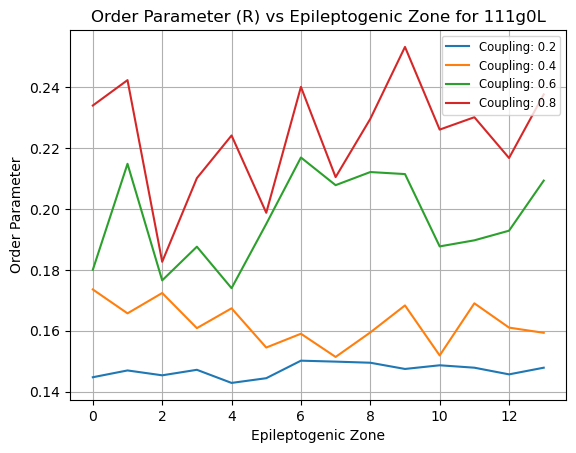

Generating plot for data_num: 112g0L
Running for coupling: 0.2
Running for coupling: 0.4
Running for coupling: 0.6
Running for coupling: 0.8
(4, 14)


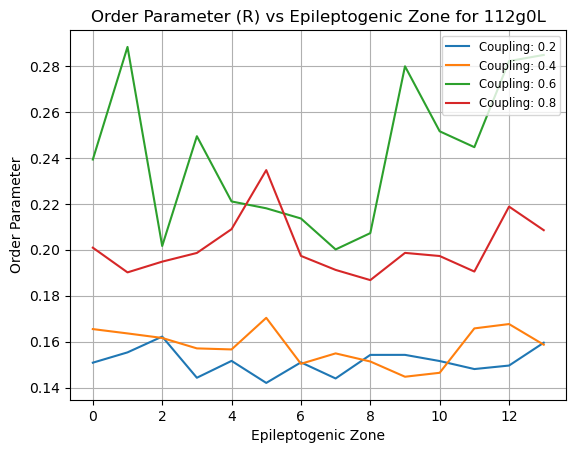

In [30]:
plot_parameter_fragment('111g0L', dt=0.1, T=1000, mean=0, std=1)
plot_parameter_fragment('112g0L', dt=0.1, T=1000, mean=0, std=1)

Generating plot for data_num: 111g0L
Running for coupling: 0.2
Running for coupling: 0.4
Running for coupling: 0.6
Running for coupling: 0.8
(4, 14)


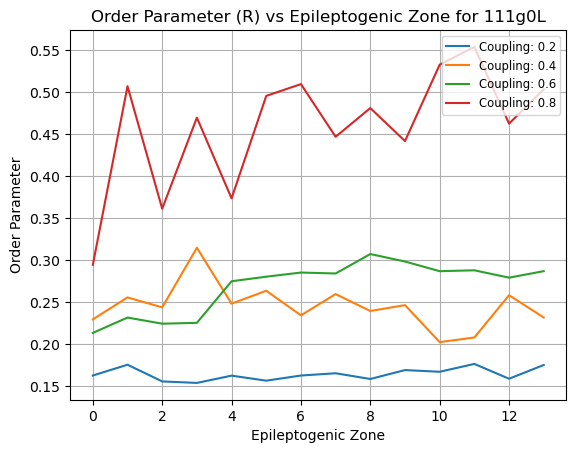

Generating plot for data_num: 112g0L
Running for coupling: 0.2
Running for coupling: 0.4
Running for coupling: 0.6
Running for coupling: 0.8
(4, 14)


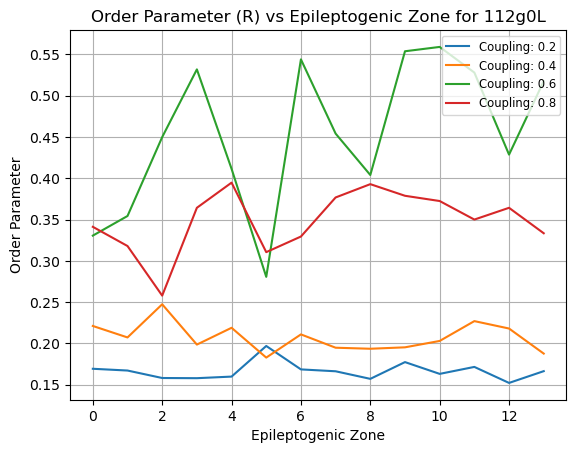

In [9]:
plot_parameter_fragment('111g0L', dt=0.1, T=1000, mean=1, std=0.5)
plot_parameter_fragment('112g0L', dt=0.1, T=1000, mean=1, std=0.5)

Generating plot for data_num:  111g0L  and fragment_num:  0
[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 1 1 1]
 ...
 [0 0 1 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 1 ... 1 1 0]]


100%|██████████| 100/100 [00:10<00:00,  9.77it/s]
100it [00:12,  7.84it/s]


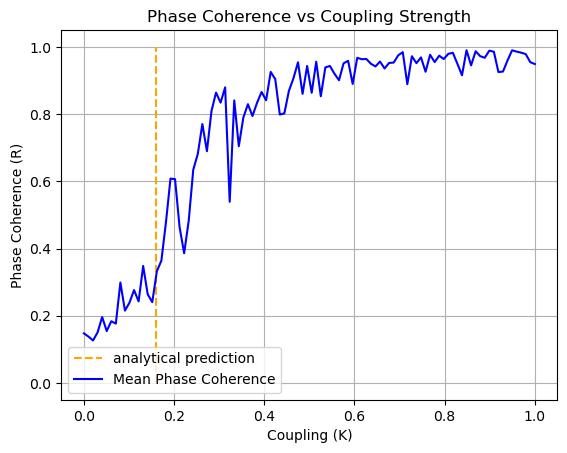

Generating plot for data_num:  111g0L  and fragment_num:  4
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [1 0 1 ... 1 0 1]
 [1 0 0 ... 1 1 0]]


100%|██████████| 100/100 [00:08<00:00, 12.25it/s]
100it [00:12,  8.33it/s]


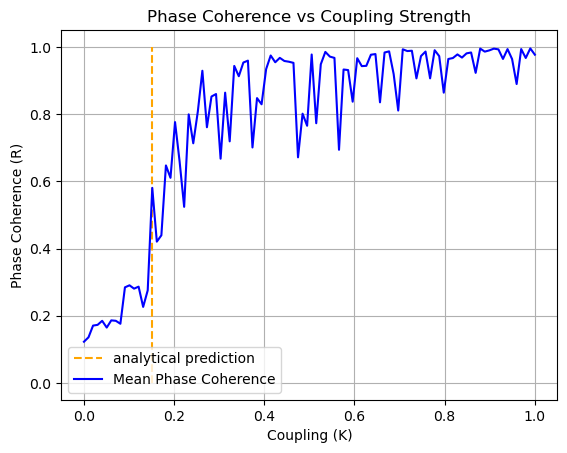

Generating plot for data_num:  111g0L  and fragment_num:  9
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 1 0 1]
 [1 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [0 1 0 ... 1 1 0]]


100%|██████████| 100/100 [00:06<00:00, 16.47it/s]
100it [00:12,  7.99it/s]


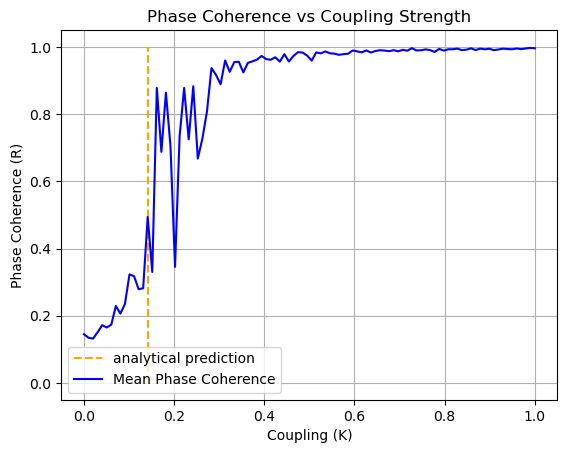

Generating plot for data_num:  111g0L  and fragment_num:  13
[[0 0 1 ... 1 0 1]
 [0 0 1 ... 1 0 0]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [0 0 1 ... 1 0 0]
 [1 0 1 ... 1 0 0]]


100%|██████████| 100/100 [00:06<00:00, 15.93it/s]
100it [00:12,  8.05it/s]


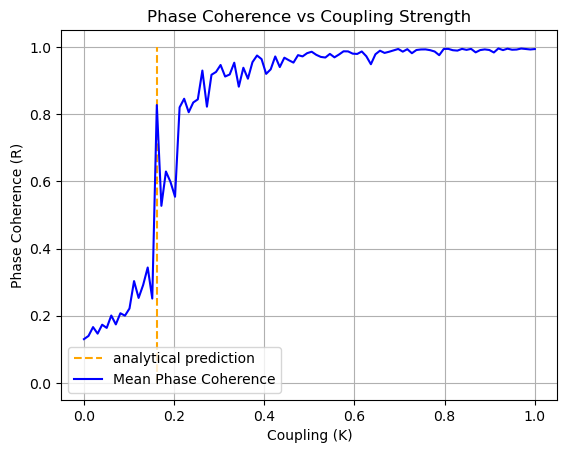

In [14]:
plot_phase_coupling("../data/binary/111g0L_0.csv", dt=0.1, T=1000, mean=1, std=0.1)
plot_phase_coupling("../data/binary/111g0L_4.csv", dt=0.1, T=1000, mean=1, std=0.1)
plot_phase_coupling("../data/binary/111g0L_9.csv", dt=0.1, T=1000, mean=1, std=0.1)
plot_phase_coupling("../data/binary/111g0L_13.csv", dt=0.1, T=1000, mean=1, std=0.1)

Generating plot for data_num:  112g0L  and fragment_num:  0
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 18.06it/s]
100it [00:09, 10.37it/s]


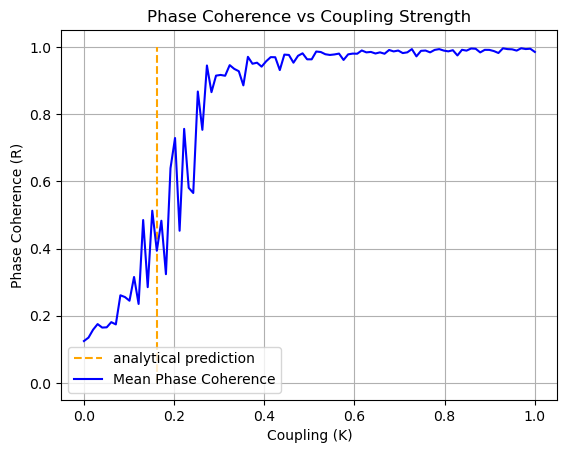

Generating plot for data_num:  112g0L  and fragment_num:  4
[[0 1 0 ... 0 0 0]
 [1 0 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 0 1 1]
 [0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 0]]


100%|██████████| 100/100 [00:04<00:00, 21.27it/s]
100it [00:09, 10.80it/s]


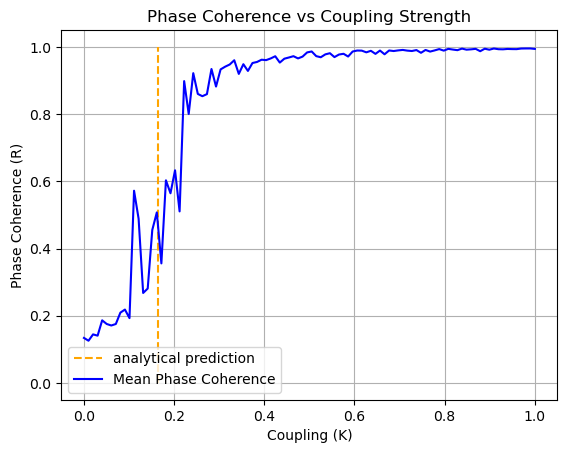

Generating plot for data_num:  112g0L  and fragment_num:  9
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]


100%|██████████| 100/100 [00:04<00:00, 21.13it/s]
100it [00:11,  8.80it/s]


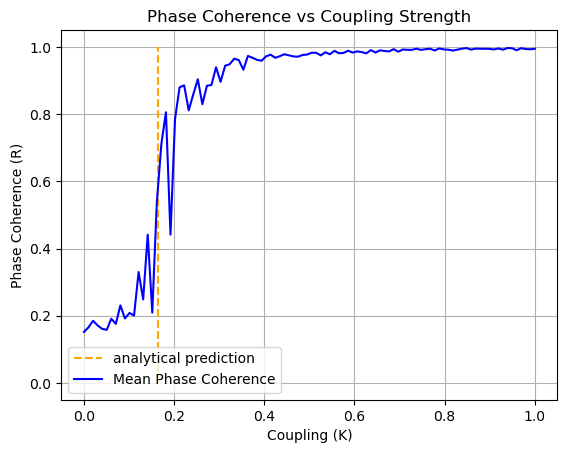

Generating plot for data_num:  112g0L  and fragment_num:  13
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 0 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 0 ... 1 0 1]
 [1 1 1 ... 1 1 0]]


100%|██████████| 100/100 [00:07<00:00, 12.80it/s]
100it [00:11,  9.01it/s]


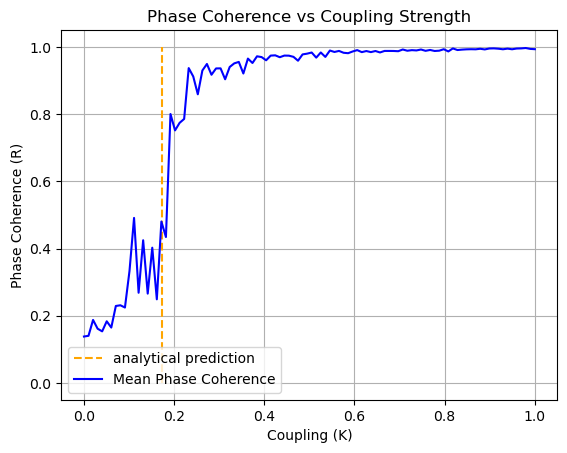

In [6]:
plot_phase_coupling("../data/binary/112g0L_0.csv", dt=0.1, T=1000, mean=1, std=0.1)
plot_phase_coupling("../data/binary/112g0L_4.csv", dt=0.1, T=1000, mean=1, std=0.1)
plot_phase_coupling("../data/binary/112g0L_9.csv", dt=0.1, T=1000, mean=1, std=0.1)
plot_phase_coupling("../data/binary/112g0L_13.csv", dt=0.1, T=1000, mean=1, std=0.1)